In [1]:
import xesmf as xe
import os,sys
import numpy as np
import xarray as xr
import zarr

# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

# plota
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}

# from dask.distributed import Client
import multiprocessing.popen_spawn_posix
from distributed import Client

c = Client()
c

<Client: 'tcp://127.0.0.1:34723' processes=4 threads=4, memory=8.39 GB>

# load OCCIPUT and IMHOTEP grids and data

In [4]:
dir_work = os.environ['WORK']
dir_sc = os.environ['SCRATCH']
diro = dir_work + "/ETUDE3/ENS_VAR_BUDGET/PLOTS/"

In [5]:
dir_data = dir_work + "/ETUDE3/ENS_VAR_BUDGET/data4analyses/"

my_regions_masks = xr.open_zarr(dir_data+"my_regions_masks.zarr")

## OCCIPUT

In [6]:
DIROCCIPUT = dir_work+"/ETUDE3/ENS_VAR_BUDGET/data4analyses/OCCIPUT/"
ds_OCCIPUT = xr.open_dataset(DIROCCIPUT+"internal_var_DIFF_mean_std.nc").rename_vars({"nlon":"lon"})

In [7]:
nav_lon_occi = ds_OCCIPUT.lon
nav_lat_occi = ds_OCCIPUT.lat

## IMHOTEP

In [8]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
chunk_size = {'y':510,'x':721} # {"x":133,"y":320} chunk(

mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size, drop_variables="time_counter").squeeze()
nav_lon_imho =  mesh_hgr.nav_lon
nav_lat_imho =  mesh_hgr.nav_lat

In [9]:
tmask = mesh_hgr.tmask[0].drop_vars('nav_lev') #.drop_vars('time_counter')

In [10]:
# load imohtep data
COMP = "SLA"

DIRIMHOTEP = dir_work + "/ETUDE3/ENS_VAR_BUDGET/data4analyses/"

nexp1 = "EGAI"
nexp3 = "ES"

# for the full depth
ds1 = xr.open_dataset(DIRIMHOTEP+nexp1+"/"+COMP+"/var_terms_39.zarr", engine="zarr")
ds3 = xr.open_dataset(DIRIMHOTEP+nexp3+"/"+COMP+"/var_terms_39.zarr", engine="zarr")
# compute the difference
DIFFEGAI_ES  = ds1 - ds3

# EGAI - ES
internal_var_DIFFEGAI_ES = DIFFEGAI_ES.intrinsic_var - DIFFEGAI_ES.res_var


In [11]:
internal_var_DIFFEGAI_ES = internal_var_DIFFEGAI_ES.assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)

In [12]:
internal_var_DIFFEGAI_ES

<xarray.DataArray (y: 1207, x: 1442)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon      (y, x) float32 dask.array<chunksize=(510, 721), meta=np.ndarray>
    lat      (y, x) float32 dask.array<chunksize=(510, 721), meta=np.ndarray>
Dimensions without coordinates: y, x

### in percentage

In [4]:
DIROCCIPUT = dir_work+"/ETUDE3/ENS_VAR_BUDGET/data4analyses/OCCIPUT/"
ds_OCCIPUT = xr.open_dataset(DIROCCIPUT+"internal_var_DIFF_mean_std_percentage.nc")#.rename_vars({"nlon":"lon"})
nav_lon_occi = ds_OCCIPUT.lon
nav_lat_occi = ds_OCCIPUT.lat

In [18]:
intrinsic_var_DIFF_perc_EGAI_ES = (np.abs(internal_var_DIFFEGAI_ES) / ds3.tot_var) *100
intrinsic_var_DIFF_perc_EGAI_ES = intrinsic_var_DIFF_perc_EGAI_ES.assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)

# REGRIDDING

In [13]:
ds_OCCIPUT

<xarray.Dataset>
Dimensions:   (y: 1021, x: 1442)
Coordinates:
    lon       (y, x) float32 ...
    lat       (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    DIFFmean  (y, x) float64 ...
    DIFFstd   (y, x) float64 ...

In [14]:
# les fonctions de regridding prennent des datasets en paramètres
regridder = xe.Regridder(ds_OCCIPUT, internal_var_DIFFEGAI_ES, "nearest_s2d") #, ignore_degenerate=True)    

#regridder = xe.Regridder(ds_OCCIPUT, intrinsic_var_DIFF_perc_EGAI_ES, "nearest_s2d") #, ignore_degenerate=True)    


#ordre :  dataset à regridder, dataset contenant la grille voulue en coordonnées
#"bilinear" j'ai pas trop compris ce que ça fait, ignore_degenerate=True 


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [3]:
# for imhotep: data
# dirww = "/gpfswork/rech/cli/uor98hu/ARCTIC_ENS/SSH/EGAI/"
# coeff_GEAI= xr.open_dataset(dirww+ "eORCA025.L75-IMHOTEP.EGAI_1993_2015_1y_EM_corr_coeff.nc").squeeze().assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)

# load occiput data
#coeff_ano= []
#for ii in range(1,51):
#    coeff_ano.append(xr.open_dataarray(dirsc+"trends/trend_occi_diff_ano_ssh_"+str(ii)+".nc")[0].squeeze().assign_coords(lon= nav_lon_occi, lat= nav_lat_occi))
#ds_ano= xr.concat(coeff_ano, "realisation").to_dataset()

In [15]:
ds_OCCIPUT_regridded= regridder(ds_OCCIPUT)   # regridding

In [16]:
ds_OCCIPUT_regridded

<xarray.Dataset>
Dimensions:   (y: 1207, x: 1442)
Coordinates:
    lon       (y, x) float32 dask.array<chunksize=(510, 721), meta=np.ndarray>
    lat       (y, x) float32 dask.array<chunksize=(510, 721), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    DIFFmean  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    DIFFstd   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    regrid_method:  nearest_s2d

In [23]:
# da_ano_regridded.to_netcdf(dirsc+ "trends/trend_occi_diff_ano_ssh_regridded_all.nc")

# Do comparison

In [3]:
# for imhotep: data
# dirww = "/gpfswork/rech/cli/uor98hu/ARCTIC_ENS/SSH/"
# coeff_EGAI = xr.open_dataset(dirww+ "EGAI/eORCA025.L75-IMHOTEP.EGAI_1993_2015_1y_EM_corr_coeff.nc").squeeze().assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)
# coeff_EAI = xr.open_dataset(dirww+ "EAI/eORCA025.L75-IMHOTEP.EAI_1993_2015_1y_EM_corr_coeff.nc").squeeze().assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)
# coeff_ES = xr.open_dataset(dirww+ "ES/eORCA025.L75-IMHOTEP.ES_1993_2015_1y_EM_corr_coeff.nc").squeeze().assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)

#coeff_EGAI_EAI = xr.open_dataarray(dirww+ "EGAI_EAI/eORCA025.L75-IMHOTEP.EGAI_EAI_1993_2015_1y_EM_corr_coeff.nc")[0].squeeze().assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)
#coeff_EAI_ES = xr.open_dataarray(dirww+ "EAI_ES/eORCA025.L75-IMHOTEP.EAI_ES_1993_2015_1y_EM_corr_coeff.nc")[0].squeeze().assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)
#coeff_EGAI_ES = xr.open_dataarray(dirww+ "EGAI_ES/eORCA025.L75-IMHOTEP.EGAI_ES_1993_2015_1y_EM_corr_coeff.nc")[0].squeeze().assign_coords(lon= nav_lon_imho, lat= nav_lat_imho)


In [17]:
DIFFamplitude = (ds_OCCIPUT_regridded.DIFFmean + 1.65 * ds_OCCIPUT_regridded.DIFFstd) * 10000 # in cm2

DIFF_imho = np.absolute(internal_var_DIFFEGAI_ES)

valid_imho = DIFF_imho.where(DIFF_imho > DIFFamplitude)


## plot with the same colorbar DIFF_imho and DIFFamplitude

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


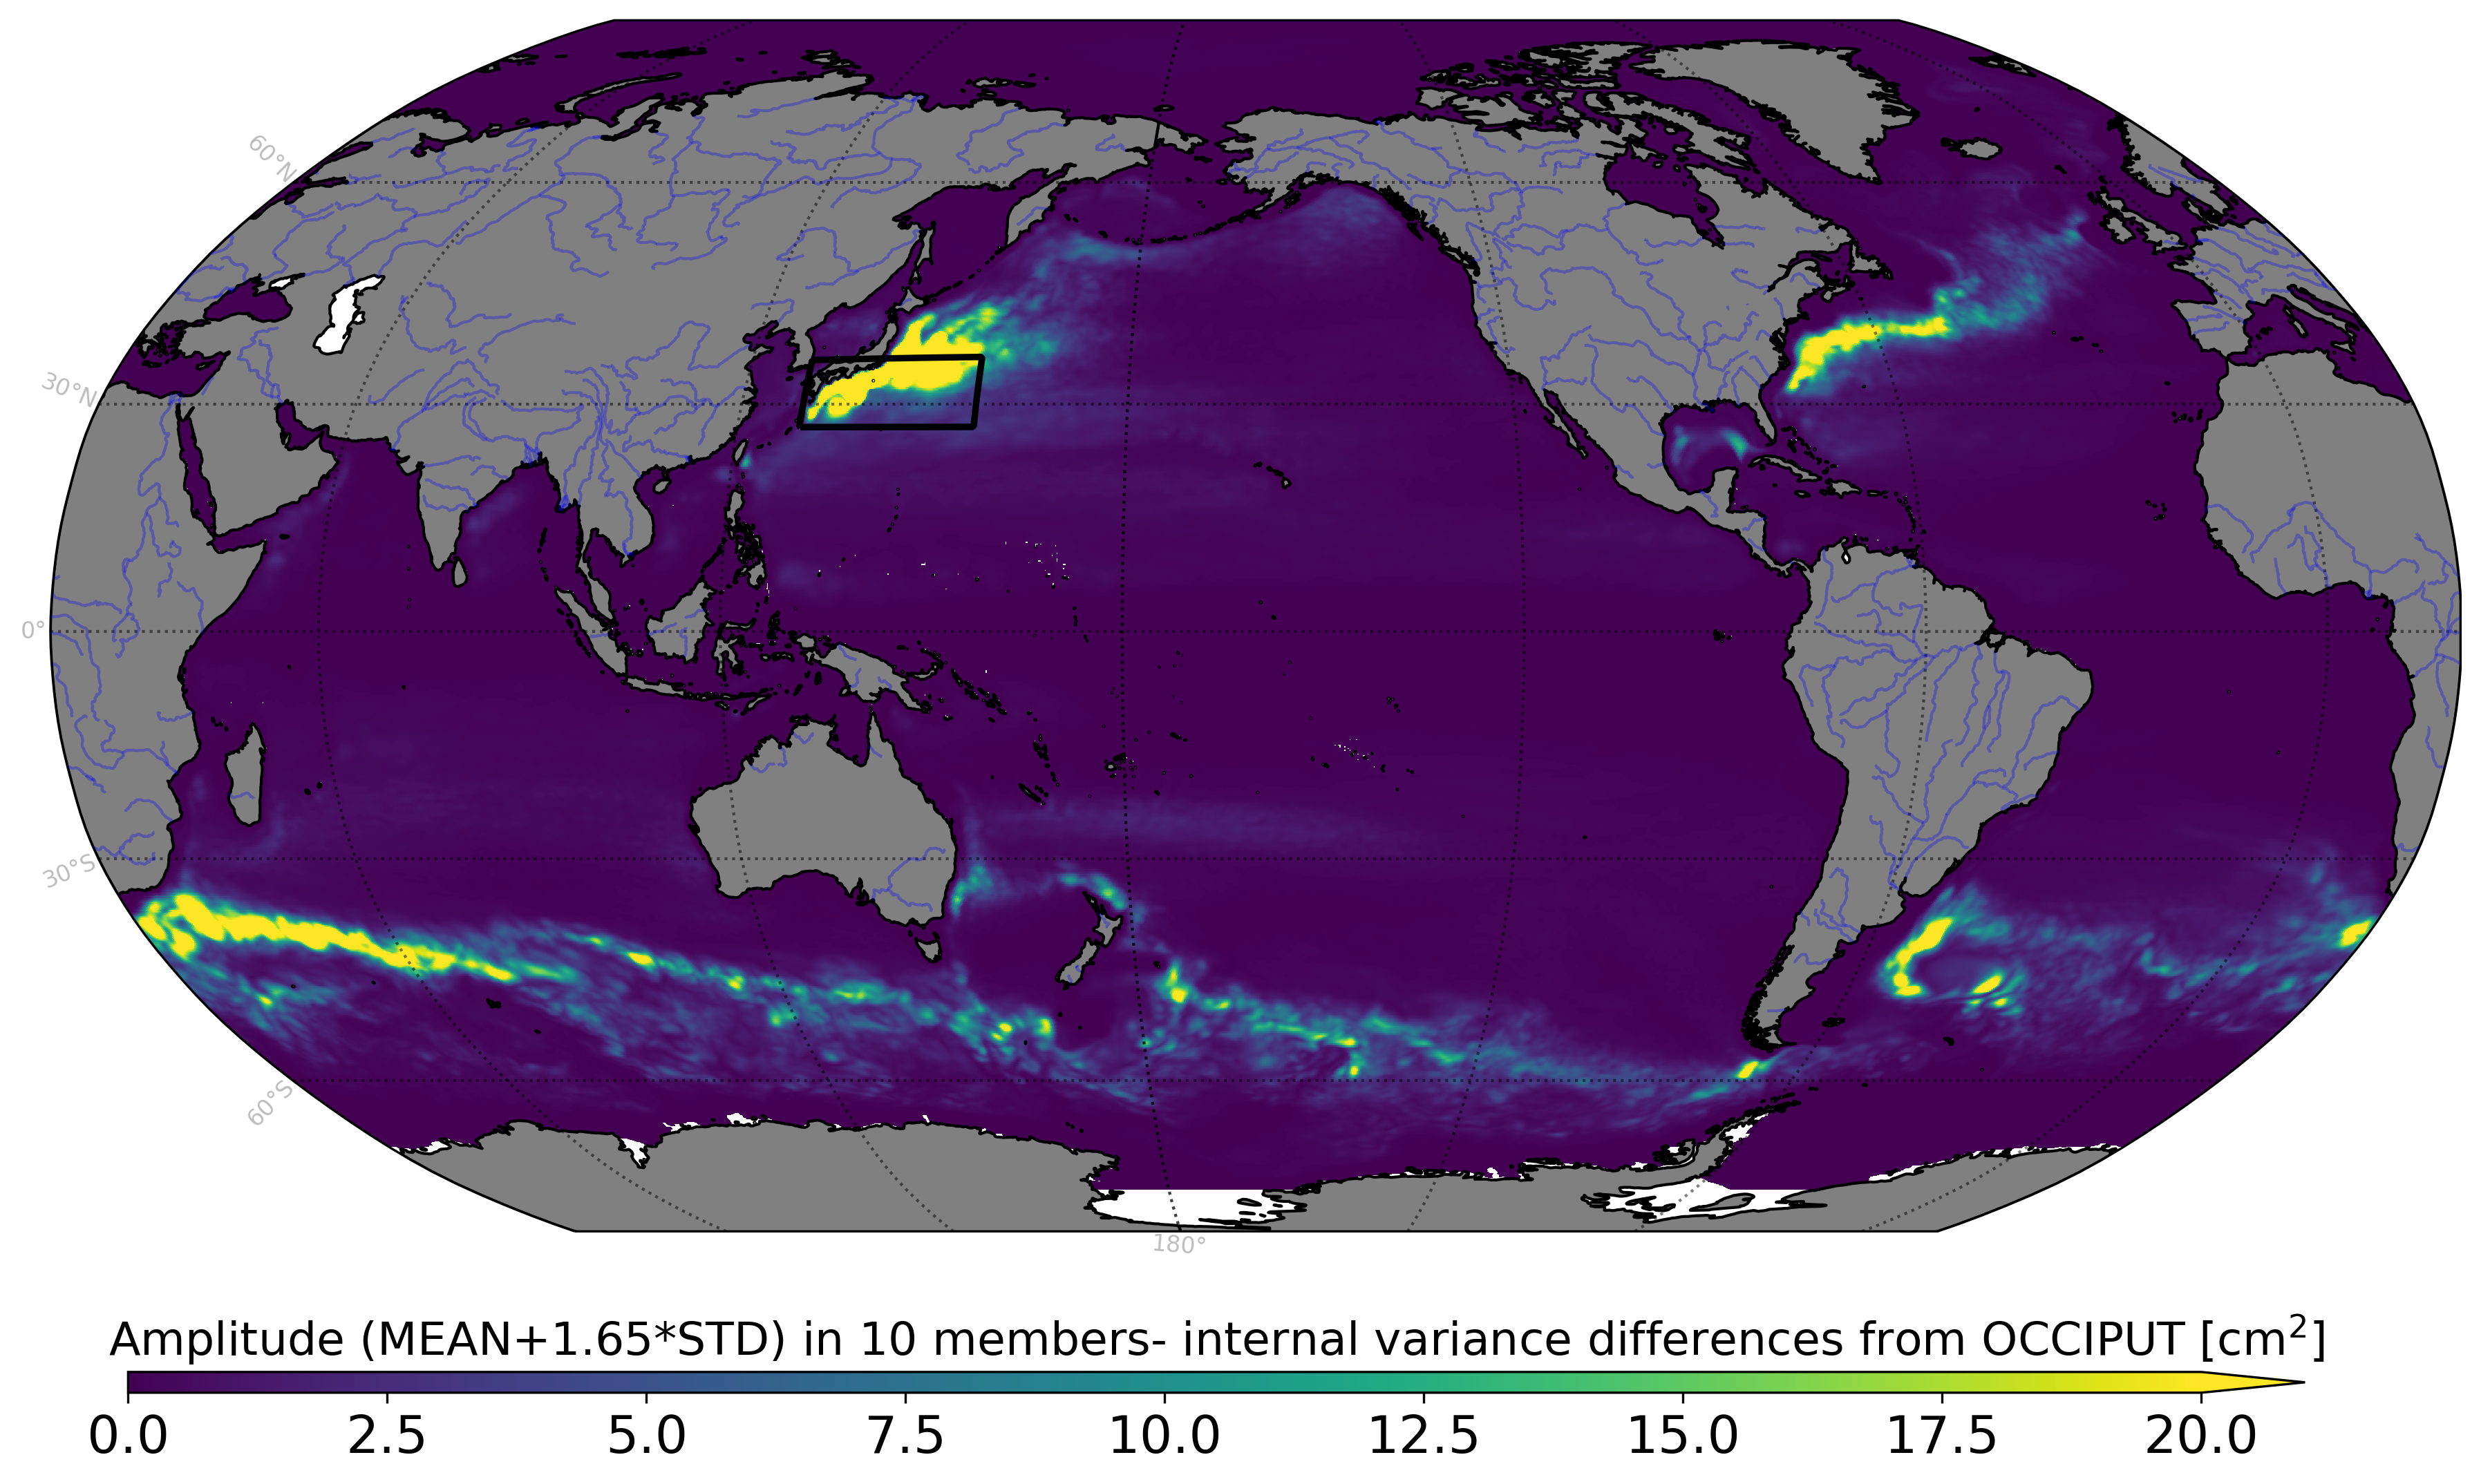

In [39]:
#Bmean=DIFFamplitude.where(MASK).values
Bmean = DIFFamplitude

fig = plt.figure(figsize=(15, 10),facecolor='white',dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.add_feature(land, edgecolor='black');
gl = ax.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = label_style; gl.ylabel_style = label_style
clr2 = ax.add_feature(rivers,alpha=0.3,facecolor='none',edgecolor='blue',zorder=6)


pcm= ax.pcolormesh(nav_lon_imho, nav_lat_imho, Bmean, shading='flat', transform=crs, vmin=0, vmax=20) #cmap =cmap12
ax.contour(nav_lon_imho,nav_lat_imho,my_regions_masks.mask_kur,1,colors="k",transform=crs,linewidths = 2)


#pcm=plt.pcolormesh(nav_lon_imho.values,nav_lat_imho.values,Bmean[0:-1,0:-1],shading='flat',transform=trdata) #,vmin=0, vmax=20

#plt.colorbar(pcm,ax=ax) #,location='bottom')

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.16, 0.7, 0.01])  #(left, bottom, width, height)

#ticklabels=np.arange(-0.5,2.5,0.5)
#new_tickslabels = [np.round(10**y,1) for y in ticklabels]

cbar = fig.colorbar(pcm,extend='max', cax=cbar_ax, orientation='horizontal') #, ticks=ticklabels) # pad = 0.025, shrink=0.9) ticks=bounds,
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticklabels(new_tickslabels)
# cbar.ax.set_title('$log_{10}(cm^{2})$',size=14)
#cbar.set_label(r'$cm^{2}$', fontsize=24)
# cbar.set_ticks(ticks=np.arange(-0.5,2.5,0.5))
plt.title(r"Amplitude (MEAN+1.65*STD) in 10 members- internal variance differences from OCCIPUT [cm$^2$]",fontsize=16)


namo = "OCCIPUT_SSH10mbs-variance_.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0)
plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none',
# plt.close(fig)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


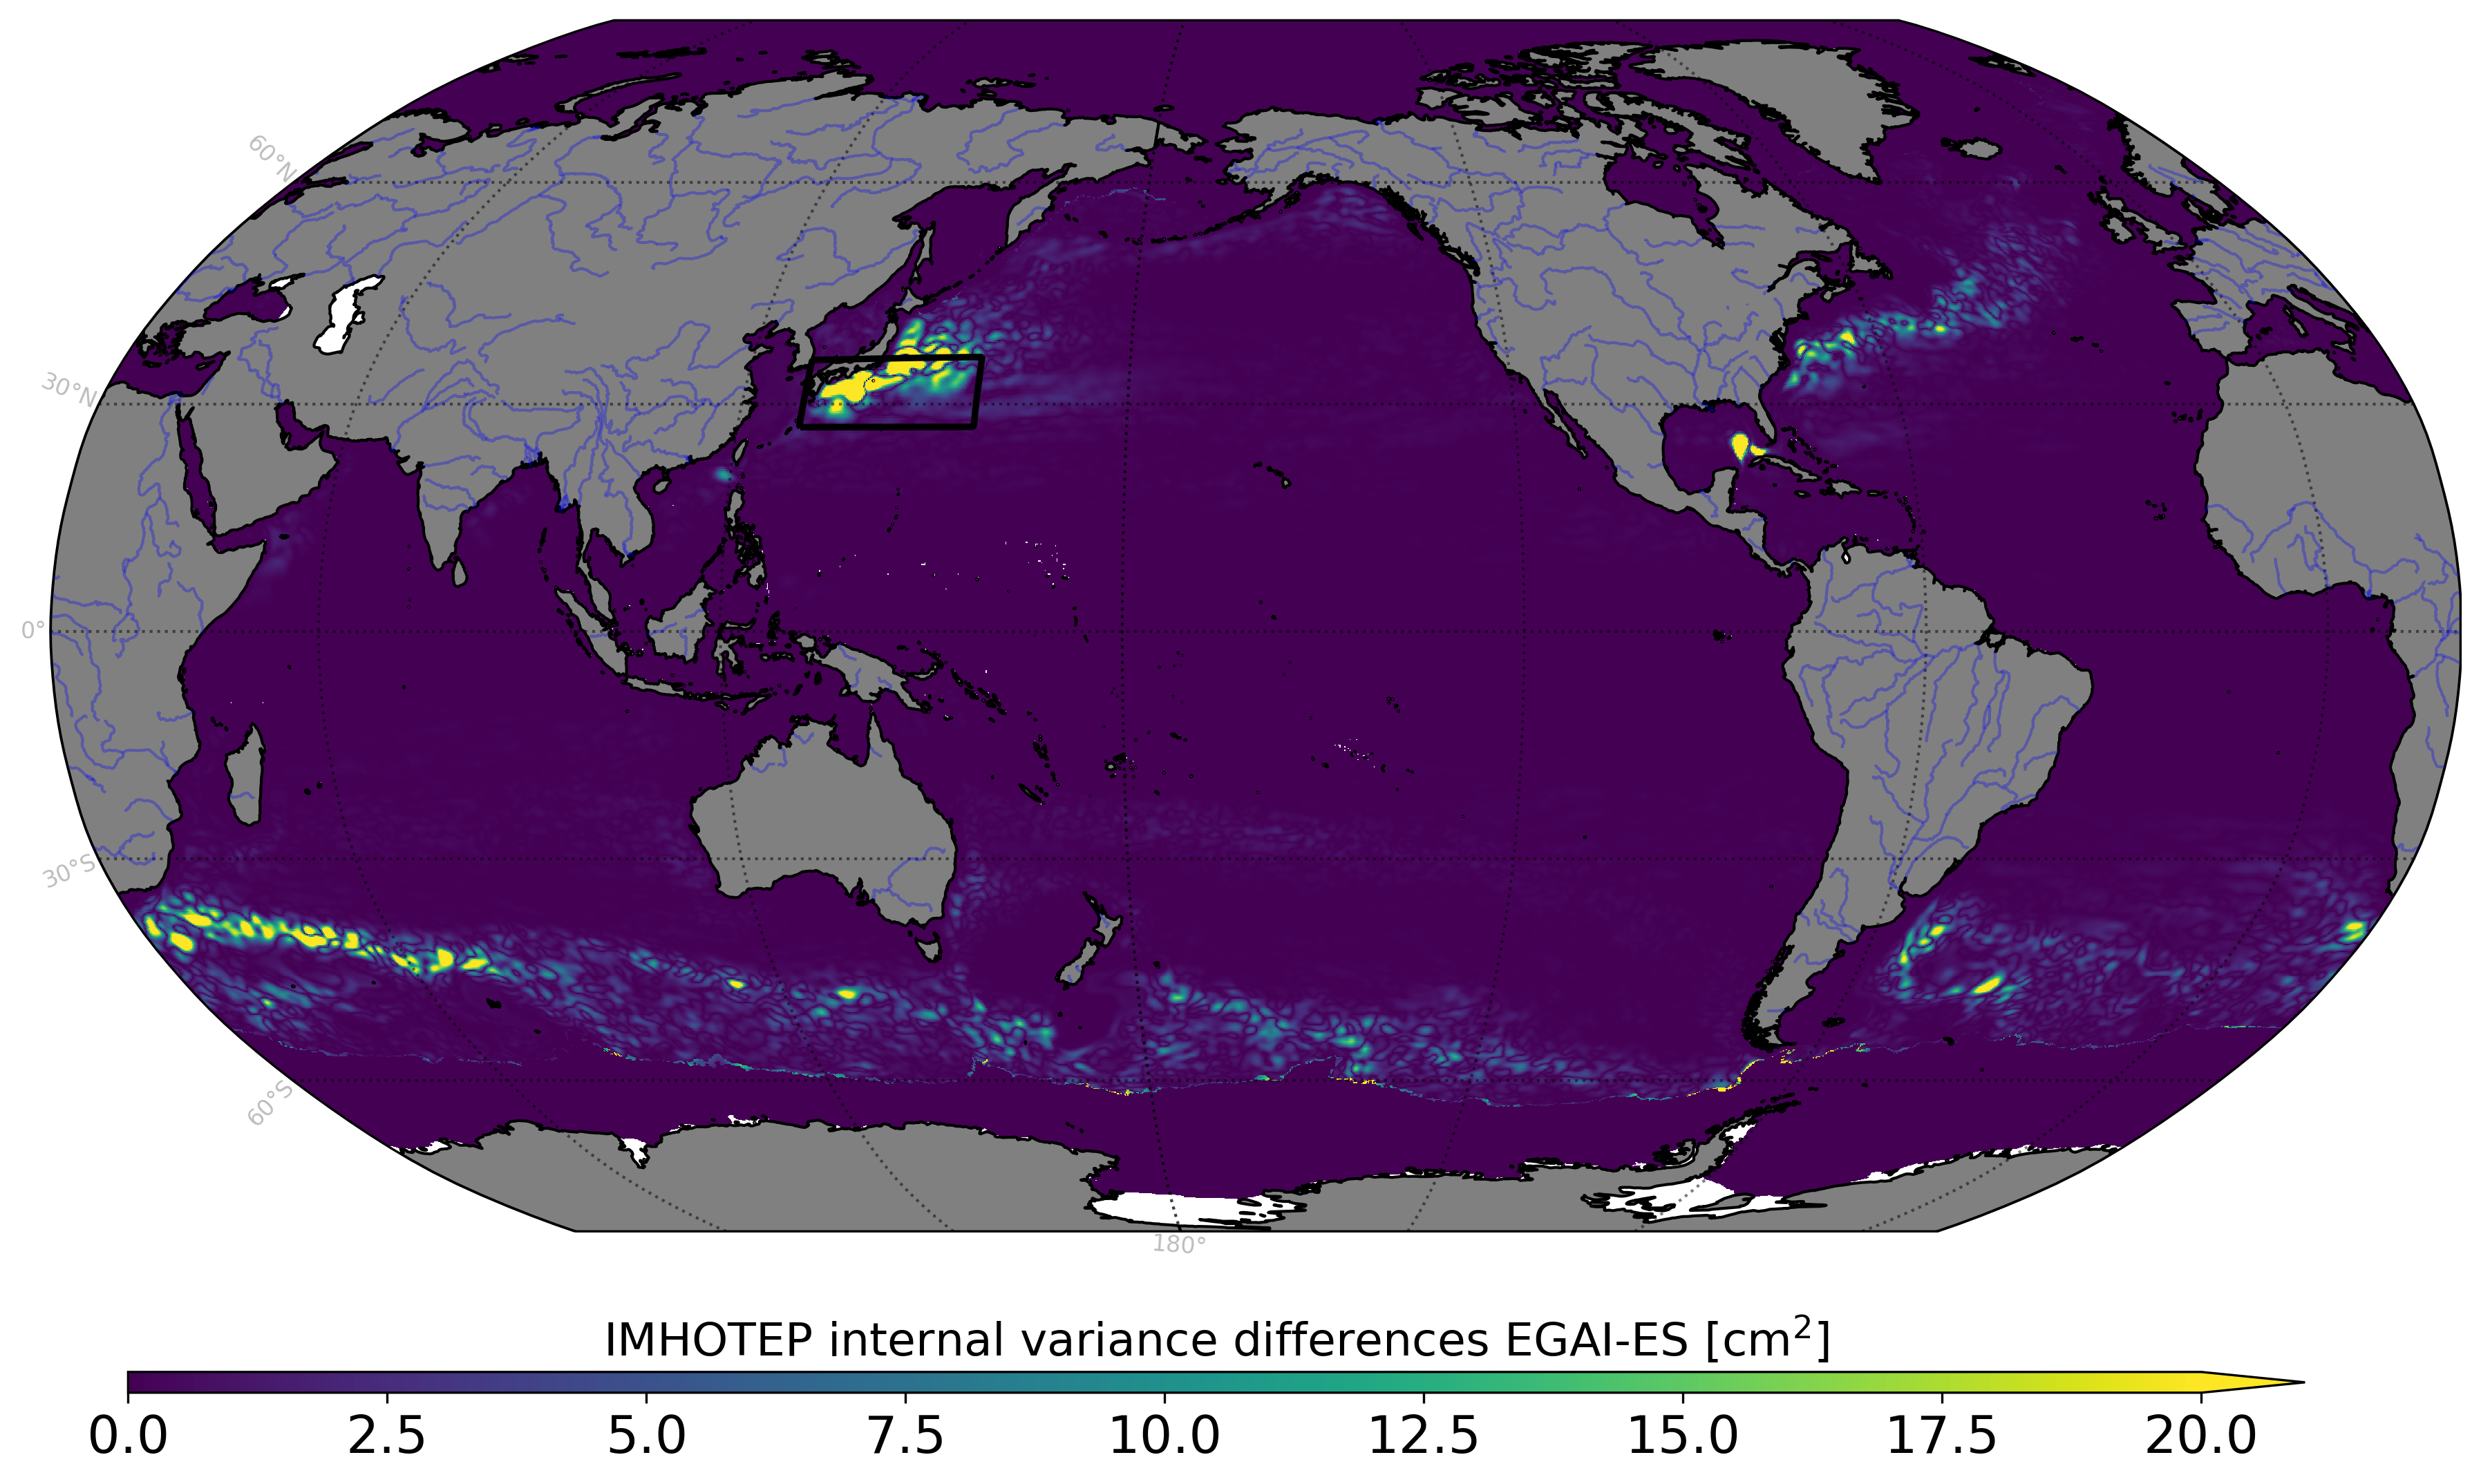

In [40]:
#Bmean=DIFFamplitude.where(MASK).values
Bmean = DIFF_imho

fig = plt.figure(figsize=(15, 10),facecolor='white',dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.add_feature(land, edgecolor='black');
gl = ax.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = label_style; gl.ylabel_style = label_style
clr2 = ax.add_feature(rivers,alpha=0.3,facecolor='none',edgecolor='blue',zorder=6)


pcm= ax.pcolormesh(nav_lon_imho, nav_lat_imho, Bmean, shading='flat', transform=crs, vmin=0, vmax=20) #cmap =cmap12
ax.contour(nav_lon_imho,nav_lat_imho,my_regions_masks.mask_kur,1,colors="k",transform=crs,linewidths = 2)


#pcm=plt.pcolormesh(nav_lon_imho.values,nav_lat_imho.values,Bmean[0:-1,0:-1],shading='flat',transform=trdata) #,vmin=0, vmax=20

#plt.colorbar(pcm,ax=ax) #,location='bottom')

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.16, 0.7, 0.01])  #(left, bottom, width, height)

#ticklabels=np.arange(-0.5,2.5,0.5)
#new_tickslabels = [np.round(10**y,1) for y in ticklabels]

cbar = fig.colorbar(pcm,extend='max', cax=cbar_ax, orientation='horizontal') #, ticks=ticklabels) # pad = 0.025, shrink=0.9) ticks=bounds,
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticklabels(new_tickslabels)
# cbar.ax.set_title('$log_{10}(cm^{2})$',size=14)
#cbar.set_label(r'$cm^{2}$', fontsize=24)
# cbar.set_ticks(ticks=np.arange(-0.5,2.5,0.5))
plt.title(r"IMHOTEP internal variance differences EGAI-ES [cm$^2$]",fontsize=16)


namo = "IMHOTEP_SSH10mbs-variance.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0)
plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none',
# plt.close(fig)

In [41]:
diro

'/lustre/fswork/projects/rech/cli/uor98hu/ETUDE3/ENS_VAR_BUDGET/PLOTS/'

(array([9.07361e+05, 1.13800e+03, 2.84000e+02, 1.19000e+02, 7.10000e+01,
        4.60000e+01, 1.60000e+01, 1.70000e+01, 1.30000e+01, 1.20000e+01]),
 array([2.82450147e-08, 2.22016263e+01, 4.44032526e+01, 6.66048790e+01,
        8.88065053e+01, 1.11008132e+02, 1.33209758e+02, 1.55411384e+02,
        1.77613010e+02, 1.99814637e+02, 2.22016263e+02]),
 <BarContainer object of 10 artists>)

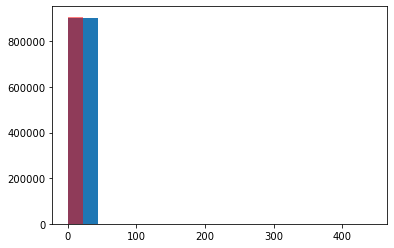

In [18]:
DIFFamplitude.plot.hist()
DIFF_imho.plot.hist(color='r',alpha=.5)

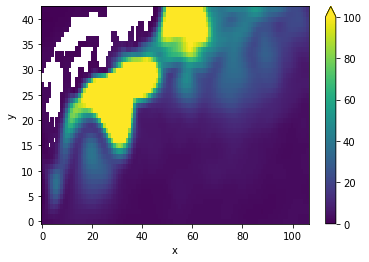

In [19]:
DIFFamplitude.where(my_regions_masks.mask_kur,drop=True).plot(vmin=0,vmax=100)

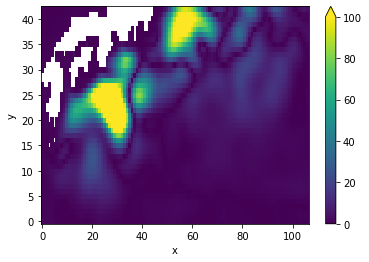

In [20]:
DIFF_imho.where(my_regions_masks.mask_kur,drop=True).plot(vmin=0,vmax=100)

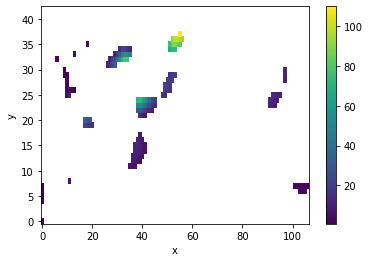

In [21]:
valid_imho.where(my_regions_masks.mask_kur,drop=True).plot()

### plot maps in percentage

In [19]:
DIFFamplitude = (ds_OCCIPUT_regridded.DIFFmean + 1.65 * ds_OCCIPUT_regridded.DIFFstd)

valid_imho_perc = intrinsic_var_DIFF_perc_EGAI_ES.where(intrinsic_var_DIFF_perc_EGAI_ES > DIFFamplitude)

(array([9.08739e+05, 2.26000e+02, 6.30000e+01, 1.50000e+01, 1.50000e+01,
        3.00000e+00, 3.00000e+00, 5.00000e+00, 4.00000e+00, 4.00000e+00]),
 array([1.76615396e-07, 1.68460662e+03, 3.36921325e+03, 5.05381987e+03,
        6.73842650e+03, 8.42303312e+03, 1.01076397e+04, 1.17922464e+04,
        1.34768530e+04, 1.51614596e+04, 1.68460662e+04]),
 <BarContainer object of 10 artists>)

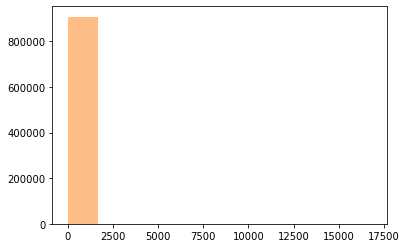

In [22]:
DIFFamplitude.plot.hist()
intrinsic_var_DIFF_perc_EGAI_ES.plot.hist(alpha=.5)

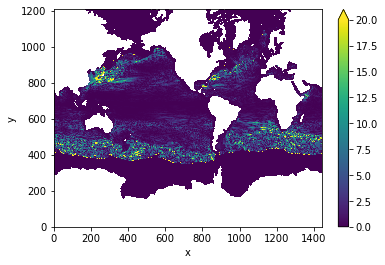

In [27]:
intrinsic_var_DIFF_perc_EGAI_ES.plot( vmin=0, vmax=20 )
#cmap34 = cm.RdYlBu_r 

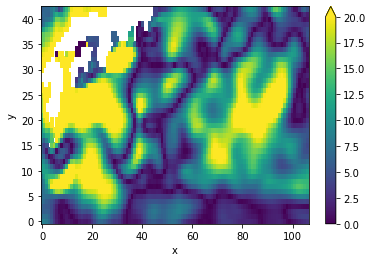

In [32]:
intrinsic_var_DIFF_perc_EGAI_ES.where(my_regions_masks.mask_kur,drop=True).plot( vmin=0, vmax=20)

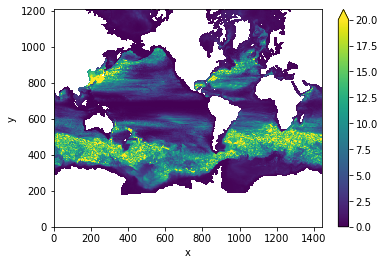

In [33]:
DIFFamplitude.plot( vmin=0, vmax=20 )

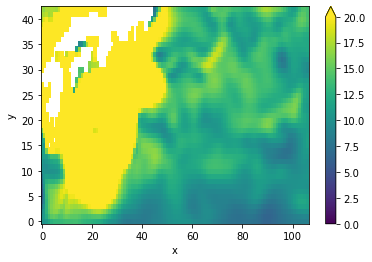

In [34]:
DIFFamplitude.where(my_regions_masks.mask_kur,drop=True).plot( vmin=0, vmax=20)

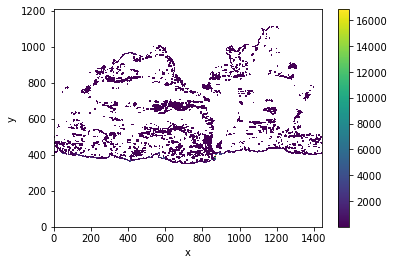

In [36]:
valid_imho_perc.plot()

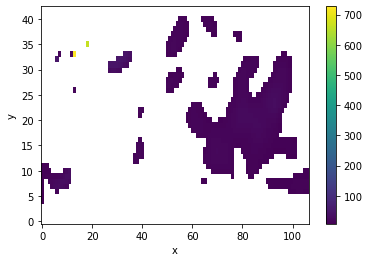

In [37]:
valid_imho_perc.where(my_regions_masks.mask_kur,drop=True).plot()

# plot map

In [30]:
dir_data = dir_work + "/ETUDE3/ENS_VAR_BUDGET/data4analyses/"
my_regions_masks = xr.open_zarr(dir_data+"my_regions_masks.zarr")

In [22]:
centim = 1/2.54  # centimeters in inches
proj = ccrs.Robinson(central_longitude=200) #ccrs.Robinson()
crs = ccrs.PlateCarree()
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

#lim_sup = 2 # cm²
#lim_inf = -0.5
# lim_l4 = 20 # %

cmap12 = cm.cool
cmap34 = cm.RdYlBu_r 

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


comp_imho_occi.png


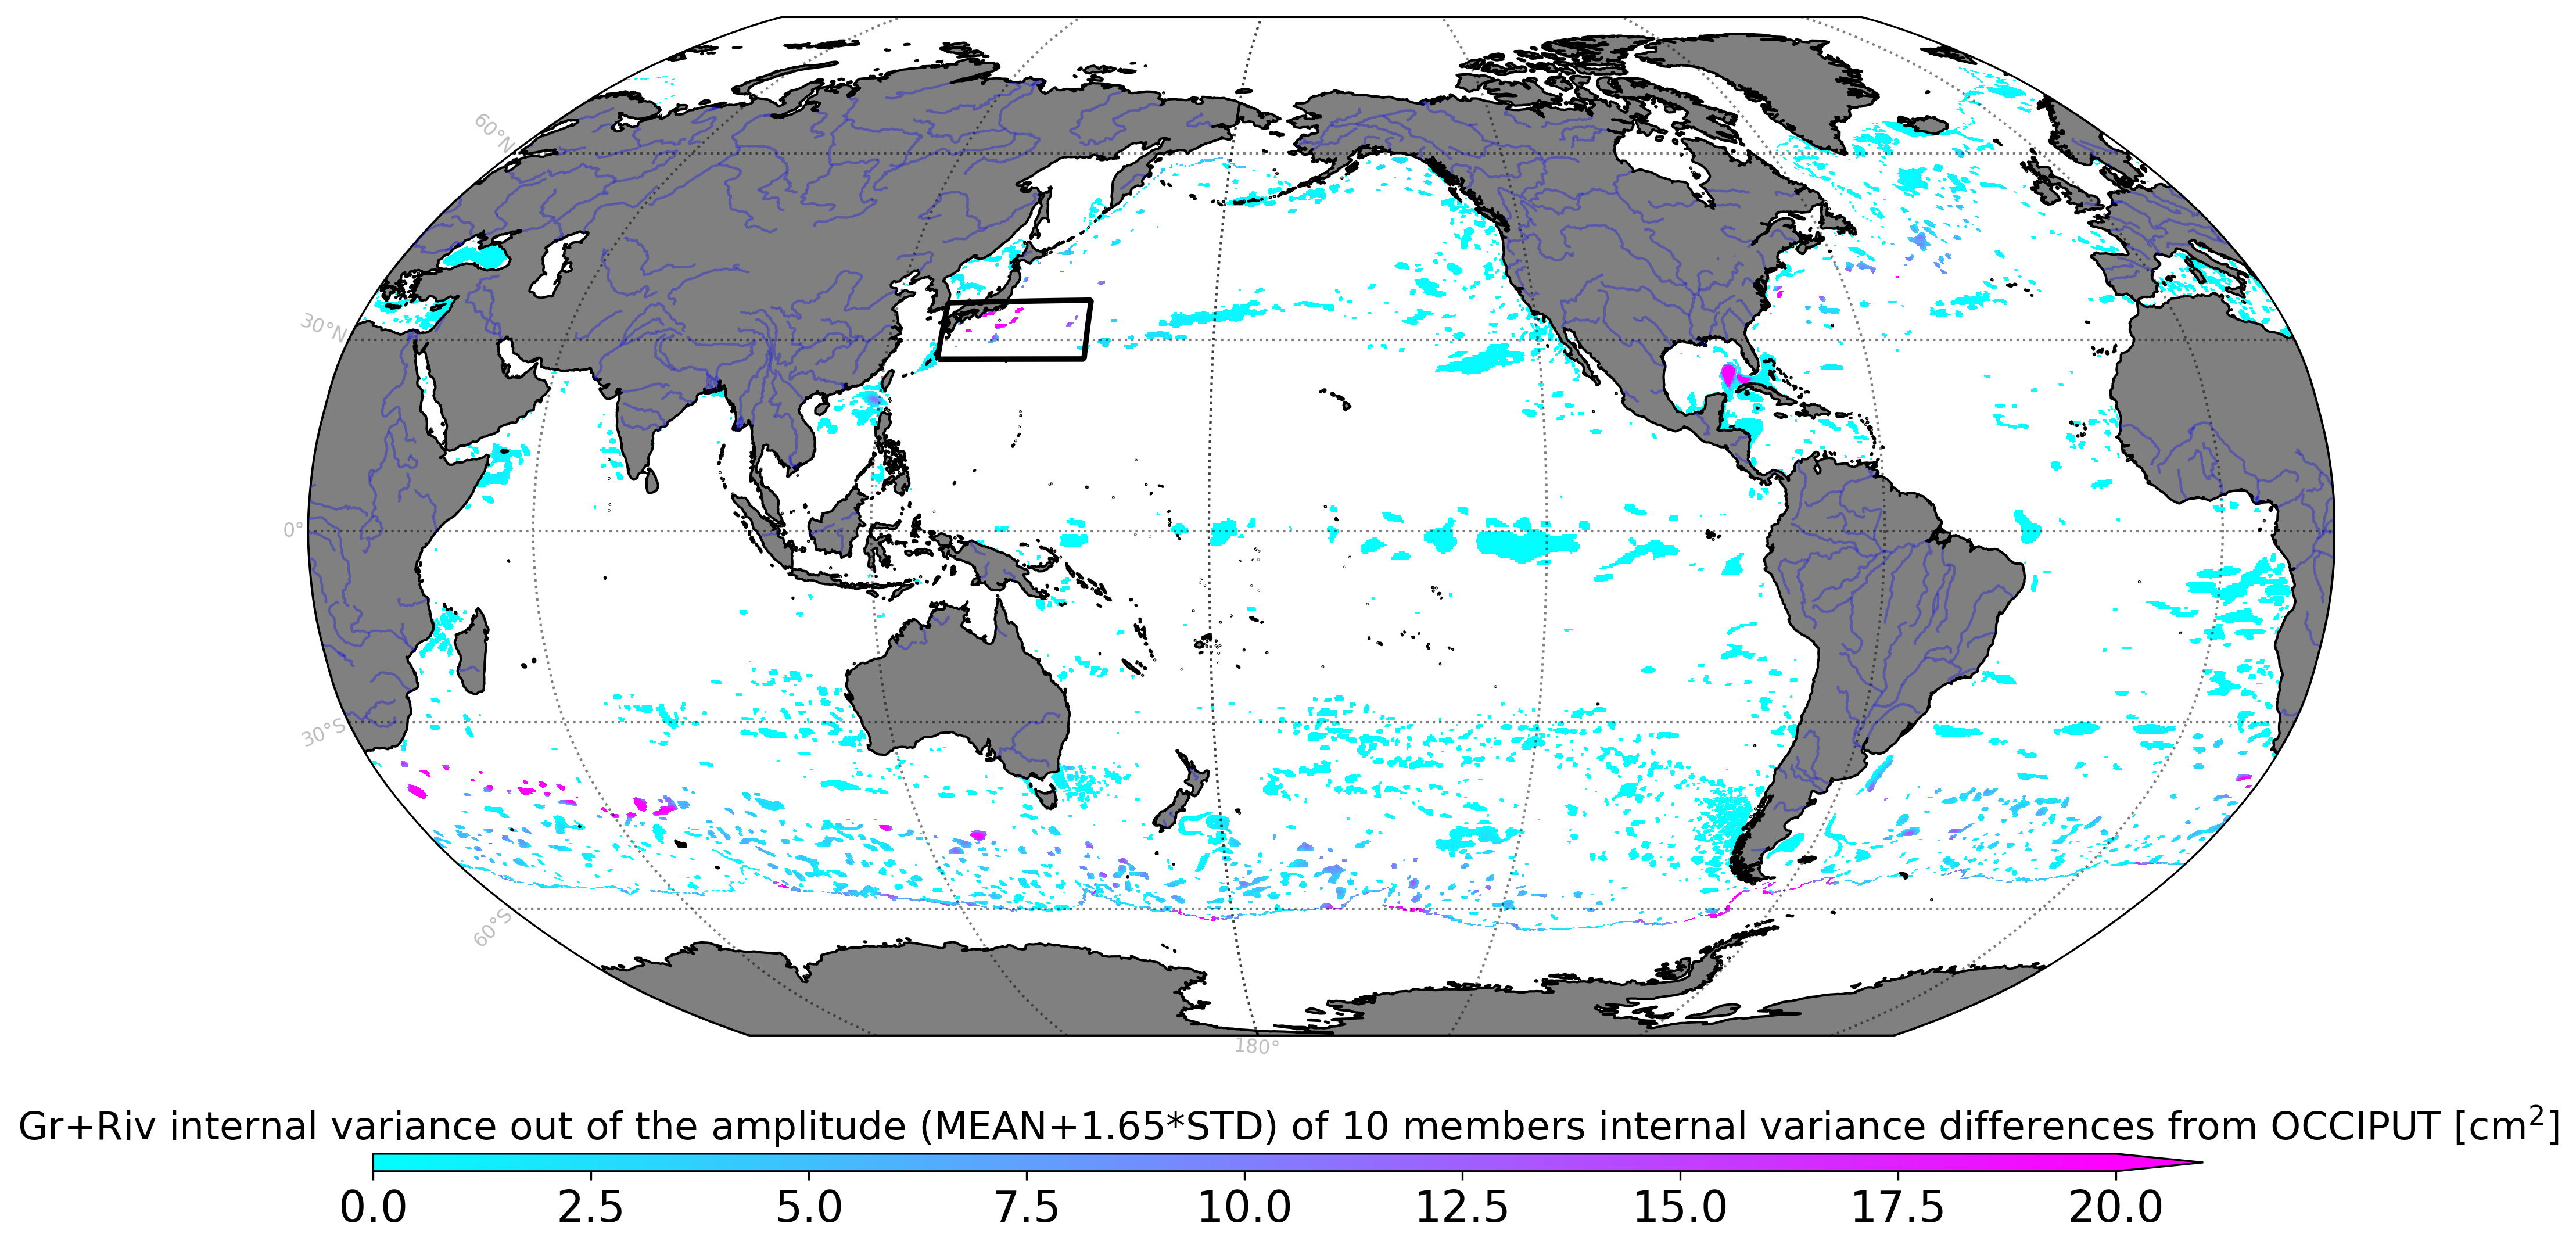

In [23]:
#Bmean=DIFFamplitude.where(MASK).values
Bmean = valid_imho

fig = plt.figure(figsize=(15, 10),facecolor='white',dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.add_feature(land, edgecolor='black');
gl = ax.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = label_style; gl.ylabel_style = label_style
clr2 = ax.add_feature(rivers,alpha=0.3,facecolor='none',edgecolor='blue',zorder=6)


pcm= ax.pcolormesh(nav_lon_imho, nav_lat_imho, Bmean, shading='flat', cmap =cmap12, transform=crs, vmin=0, vmax=20)
ax.contour(nav_lon_imho,nav_lat_imho,my_regions_masks.mask_kur,1,colors="k",transform=crs,linewidths = 2)


#pcm=plt.pcolormesh(nav_lon_imho.values,nav_lat_imho.values,Bmean[0:-1,0:-1],shading='flat',transform=trdata) #,vmin=0, vmax=20

#plt.colorbar(pcm,ax=ax) #,location='bottom')

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.16, 0.7, 0.01])  #(left, bottom, width, height)

#ticklabels=np.arange(-0.5,2.5,0.5)
#new_tickslabels = [np.round(10**y,1) for y in ticklabels]

cbar = fig.colorbar(pcm,extend='max', cax=cbar_ax, orientation='horizontal') #, ticks=ticklabels) # pad = 0.025, shrink=0.9) ticks=bounds,
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticklabels(new_tickslabels)
# cbar.ax.set_title('$log_{10}(cm^{2})$',size=14)
#cbar.set_label(r'$cm^{2}$', fontsize=24)
# cbar.set_ticks(ticks=np.arange(-0.5,2.5,0.5))

plt.title(r"Gr+Riv internal variance out of the amplitude (MEAN+1.65*STD) of 10 members internal variance differences from OCCIPUT [cm$^2$]",fontsize=16)

namo = "comp_imho_occi.png"
print(namo)
# fig.tight_layout(pad=0, h_pad=5, w_pad=0)
plt.show()
#fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none',
# plt.close(fig)

In [101]:
diro+namo

'/lustre/fswork/projects/rech/cli/uor98hu/ETUDE3/ENS_VAR_BUDGET/PLOTS/comp_imho_occi.png'

# axelle

In [6]:
# calcul des limites de l'intervalle de confiance
coeff= 1.65
occi_mean = da_ano_regridded.mean("realisation")
ecart = coeff * da_ano_regridded.std("realisation")

da_add = occi_mean + ecart
da_sub = occi_mean - ecart

In [12]:
def calcul_exp_out_spread_v2(da_exp, da_add, da_sub, chemin, name_exp):   # datarray (egai-eai), datarray (occi_ano), int (pour l'intervalle de confiance), str

    exp_plus_val  = da_exp.where(da_exp>=0)
    exp_minus_val = da_exp.where(da_exp<=0)

    part1 = exp_plus_val.where(exp_plus_val>=da_add,1)
    part2 = exp_minus_val.where(exp_minus_val<=da_sub,1)
    
    final = part1*part2

    test = (final.where(final!=1))#.where(tmask==1)
    
    test.to_netcdf(dirsc+ chemin+ name_exp+ "_trend_out_of_spread_diff_ano_occi_std_v3.nc")

In [13]:
calcul_exp_out_spread_v2(coeff_EGAI_EAI, da_add, da_sub, "trends/out_of_spread/", "EGAI-EAI")

In [14]:
calcul_exp_out_spread_v2(coeff_EGAI_ES, da_add, da_sub, "trends/out_of_spread/", "EGAI-ES")

In [15]:
calcul_exp_out_spread_v2(coeff_EAI_ES, da_add, da_sub, "trends/out_of_spread/", "EAI-ES")

In [46]:
def calcul_exp_out_spread(da_exp, da_spread, coeff, chemin, name_exp):   # datarray (egai-eai), datarray (occi_ano), int (pour l'intervalle de confiance), str

    # calcul des limites de l'intervalle de confiance
    occi_mean = da_spread.mean("realisation")
    ecart = coeff*da_spread.std("realisation")
    
    da_add = occi_mean + ecart
    da_sub = occi_mean - ecart
    
    da1= da_add - da_exp   # on étudie la différence entre mean+1.65*std et alpha[EGAI-EAI]
    da2= da_sub - da_exp
    
    da1_true= da1.where(da1<=0)   # 1ère cond: eta au dessus du spread
    da2_true= da2.where(da2>=0)   #2e cond: eta en dessous du spread
    
    test= (da1_true.combine_first(da2_true))    # combinaison spatiale des deux conditions (da1_true et da2_true)
    test2= (test.fillna(1)*tmask).squeeze()  # on fixe les continents à 0 (multiplication avec mask) et les points où eta est dans le spread à 1
    test3= xr.where(test2==0, np.nan, test2)     # continents --> nan 
    test4= xr.where(test3==1, 0, test3)       # valeurs où eta est dans le spread --> 0
    
    cond= np.logical_or(test4<0, test4>0)      # ie test4!= nan
    da_out_sprd= xr.where(cond, da_exp, np.nan)   # on garde les valeurs de l'exp là où on est hors du spread et on met des nan ailleurs
    
    da_out_sprd.to_netcdf(dirsc+ chemin+ name_exp+ "_trend_out_of_spread_diff_ano_occi_std.nc")